In [1]:
# Load packages
library(mgcv)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(grid)
library(writexl)
library(magrittr)
library(rstatix)
library(mice)

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::collapse() masks nlme::collapse()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attac

In [2]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
getwd()
rsv.data <- read_csv(file = "Data/infection_status.csv")

[1] "C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project"

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rsv.data <- rsv.data %>%
  # Get day of the year of birthday (= number between 1 and 365)
  mutate(
    Birth_doy = birthday %>% yday()
  ) %>%
  # Alter number of housefold members 1 == no siblings, >1 == having siblings
  mutate(
    household04_counts = case_when(
      age_days/365 >= 5 ~ (household04 + 1),  #because the child itself is also included in household size
      age_days/365 < 5 ~ household04)       #the household04 of children of age 5 should also include the child itself
  ) %>%
  # Make number of siblings 0-4 years binary factor variable
  mutate(
    Siblings04 = case_when(
      household04_counts <= 1 ~ 'False',
      household04_counts > 1 ~ 'True'
    ) %>% 
      factor()
  ) %>%
  # Make number of siblings 5-9 years binary factor variable
  mutate(
    Siblings59 = case_when(
      household59 <= 0 ~ 'False',
      household59 > 0 ~ 'True'
    ) %>% 
      factor()
  ) %>% 
  # Set nursery 0 1 to False True
  mutate(
    Nursery = case_when(
      visitnursery_child == 0 ~ 'False',
      visitnursery_child == 1 ~ 'True'
    ) %>% 
      factor()
  )

In [4]:
rsv.data <- rsv.data %>%
 mutate(
    Birth_mo = birthday %>% month()
  )

In [5]:
season_border = "10-01" #MM-DD
spring <- c(3, 4, 5)
summer <- c(6, 7, 8)
autumn <- c (9, 10, 11)
winter <- c(1, 2, 12)
rsv.data <- rsv.data %>%
  mutate(
    age_years = case_when(
      age_days <= 30.41*6 ~ '0-6 months',
      age_days > 30.41*6 & age_days <= 30.41*12 ~ '6-12 months',
      age_days > 30.41*12 & age_days <= 30.41*24 ~ '1-2 years',
      age_days > 30.41*24 & age_days <= 30.41*36 ~ '2-3 years',
      age_days > 30.41*36 & age_days <= 30.41*48 ~ '3-4 years',
      age_days > 30.41*48  ~ '4-5 years'
    ) %>% 
      factor()
    ) %>%
  mutate(
   seasons = case_when(
    consultdate < paste("2006-", season_border, sep = "")  ~ "2005/2006", 
    (consultdate >= paste("2006-", season_border, sep = "") &  consultdate < "2010-01-01") ~ "2006/2007",
    (consultdate >= "2010-01-01" &  consultdate < paste("2016-", season_border, sep = "")) ~ "2015/2016",
    consultdate >= paste("2016-", season_border, sep = "")  ~ "2016/2017")
  ) %>% 
  # Variable for the two cohorts
  mutate(
    cohort = if_else(seasons == "2005/2006" | seasons == "2006/2007", "2006/2007", "2016/2017")
      )%>%
    mutate(
        season_birth = case_when(
            Birth_mo %in% spring ~ "Spring",
            Birth_mo %in% summer ~ "Summer",
            Birth_mo %in% autumn ~ "Autumn",
            Birth_mo %in% winter ~ "Winter")
        ) %>%
  mutate(
    nursery_house = case_when(
      visitnursery_house <= 0 ~ 'False',
      visitnursery_house > 0 ~ 'True'
    ) %>% 
      factor()
    )%>%
    mutate(
        pre_term = case_when(
            pregnancytime < 37.0 ~ 'True',
            pregnancytime >= 37.0 ~ 'False'
            ) %>%
            factor()
        )

In [6]:
rsv.data <- rsv.data %>%
 mutate(
    total_cont = case_when(
        contacttotal == 0 ~ '0',
        contacttotal >= 1 & contacttotal <= 2 ~ '1-2',
        contacttotal >= 3 & contacttotal <= 5 ~ '3-5',
        contacttotal >= 6 & contacttotal <= 10 ~ '6-10',
        contacttotal >= 11 & contacttotal <= 20 ~ '11-20',
        contacttotal >= 21 & contacttotal <= 50 ~ '21-50',
        contacttotal > 50  ~ '50+'
  )
)%>%
mutate(
    total_cont04 = case_when(
        contact04 == 0 ~ '0',
        contact04 >= 1 & contact04 <= 2 ~ '1-2',
        contact04 >= 3 & contact04 <= 5 ~ '3-5',
        contact04 >= 6 & contact04 <= 10 ~ '6-10',
        contact04 >= 11 & contact04 <= 20 ~ '11-20',
        contact04 >= 21 & contact04 <= 40 ~ '21-40'
  )
)%>%
 mutate(
    total_cont59 = case_when(
        contact59 == 0 ~ '0',
        contact59 >= 1 & contact59 <= 2 ~ '1-2',
        contact59 >= 3 & contact59 <= 5 ~ '3-5',
        contact59 >= 6 & contact59 <= 10 ~ '6-10',
        contact59 >= 11 & contact59 <= 20 ~ '11-20',
        contact59 >= 21 & contact59 <= 50 ~ '21-50'
  )
)

In [8]:
# remove redundant parameters
clean <- subset(rsv.data, select = -c(contact04, contact59, contacttotal, visitnursery_child, visitnursery_house, pregnancytime, household04))

In [20]:
#look at total contacts and nursery only since they are used in the model
clean_subs <- subset(clean, select = c(total_cont, Nursery))
missing_cont <- subset(clean_subs, is.na(total_cont) == T)
missing_cont_and_nursery <- subset(missing_cont, is.na(Nursery) == T)

,Nursery,total_cont,
568,1,1,0
92,1,0,1
18,0,1,1
4,0,0,2
,22,96,118


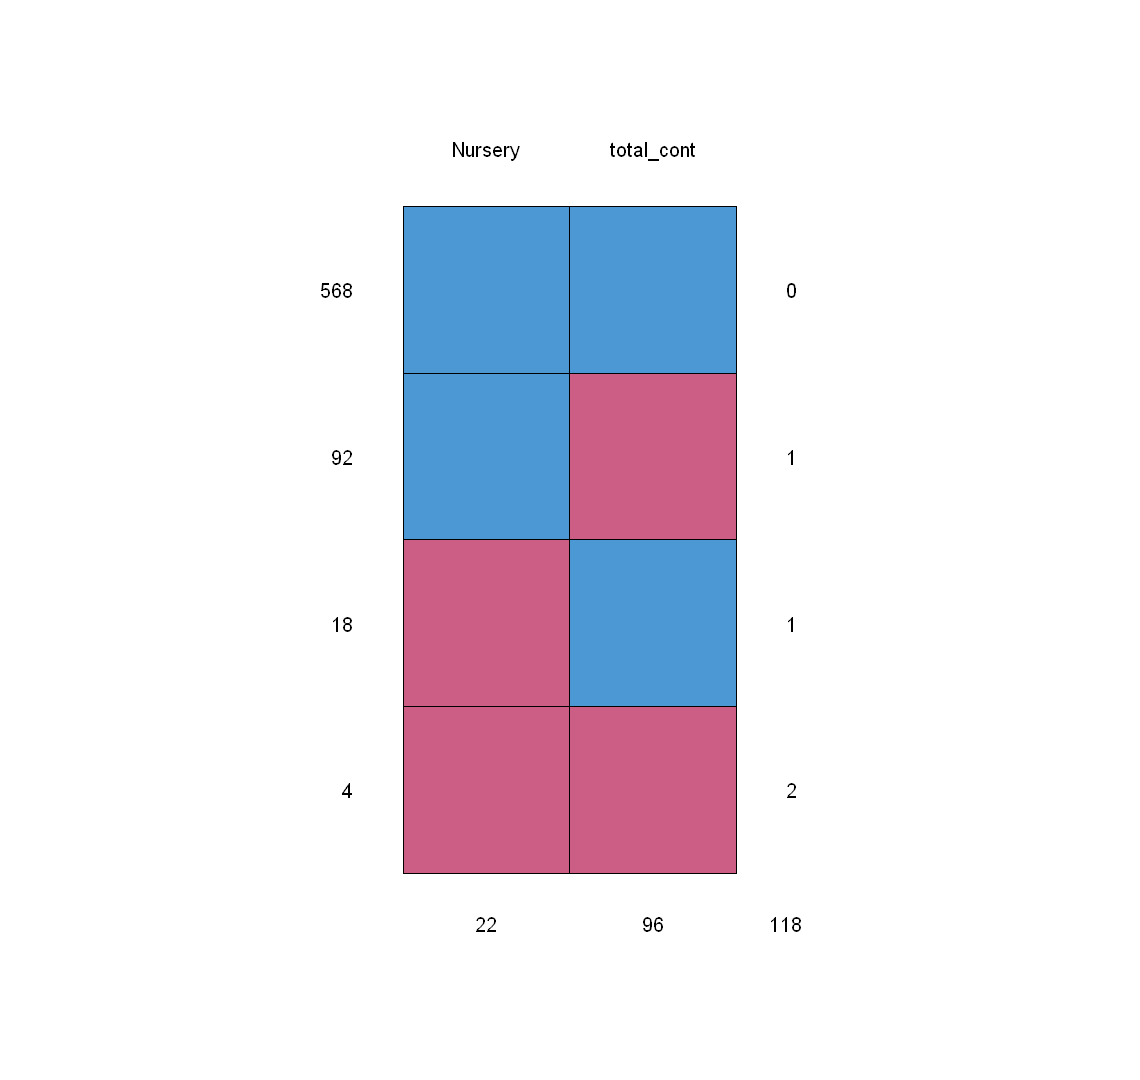

In [21]:
md.pattern(clean_subs, plot = TRUE, rotate.names = FALSE)

,age_days,birthday,consultdate,infection,IgG_PreF,IgG_PostF,IgG_Ga,IgG_Gb,IgG_N,household59,⋯,total_cont,total_cont04,total_cont59,IgA_PreF,IgA_PostF,IgA_Ga,IgA_Gb,pre_term,IgA_Nn_household,
132,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,0,1
201,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,0,0,2
76,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,0,0,0,0,1,0,5
62,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,0,0,0,0,0,0,6
30,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,1,1,1,1,1,0,3
6,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,1,1,1,1,0,0,4
17,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,0,0,0,0,1,0,7
3,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,0,0,0,0,0,0,8
79,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,1,1,1,1,0,0,5
4,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,9


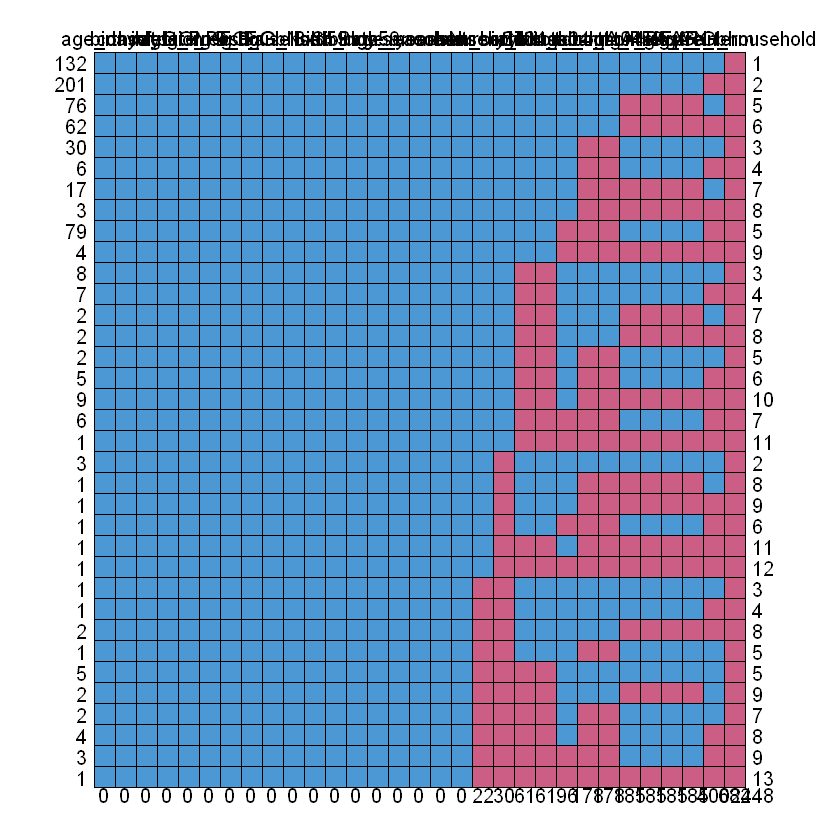

In [11]:
md.pattern(clean, plot = TRUE, rotate.names = FALSE)

Warning message:
"attributes are not identical across measure variables;
they will be dropped"
`summarise()` has grouped output by 'key', 'total'. You can override using the `.groups` argument.
Warning message:
"Removed 18 rows containing missing values (position_stack)."


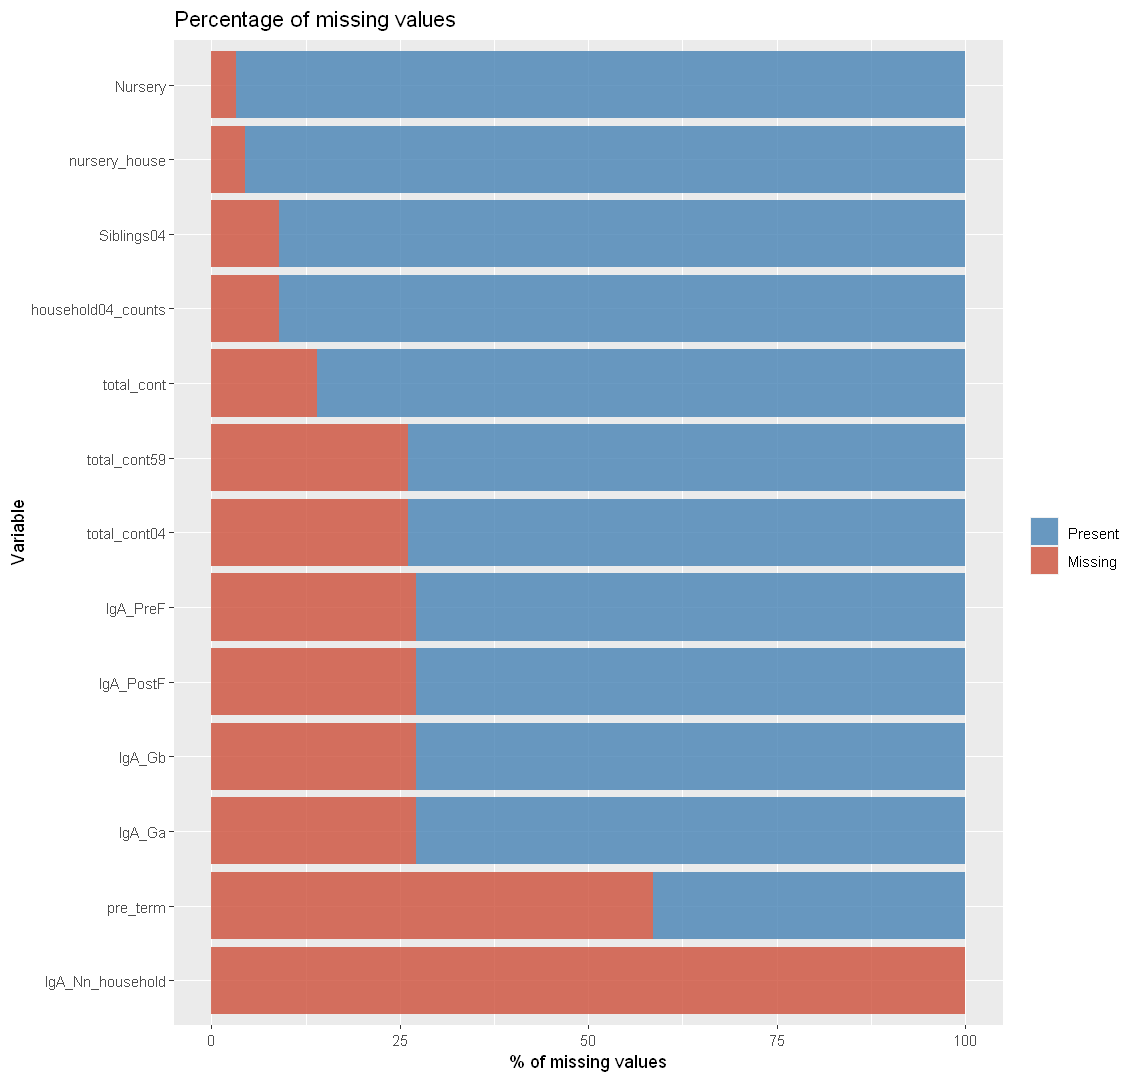

In [19]:
missing.values <- clean %>%
  gather(key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  group_by(key) %>%
  mutate(total = n()) %>%
  group_by(key, total, isna) %>%
  summarise(num.isna = n()) %>%
  mutate(pct = num.isna / total * 100)

levels <- (missing.values  %>% filter(isna == T) %>% arrange(desc(pct)))$key

percentage.plot <- missing.values %>%
      ggplot() +
        geom_bar(aes(x = reorder(key, desc(pct)), 
                     y = pct, fill=isna), 
                 stat = 'identity', alpha=0.8) +
      scale_x_discrete(limits = levels) +
      scale_fill_manual(name = "", 
                        values = c('steelblue', 'tomato3'), labels = c("Present", "Missing")) +
      coord_flip() +
      labs(title = "Percentage of missing values", x =
             'Variable', y = "% of missing values")

percentage.plot

Warning message:
"attributes are not identical across measure variables;
they will be dropped"
Warning message:
"Removed 12276 rows containing missing values (geom_raster)."


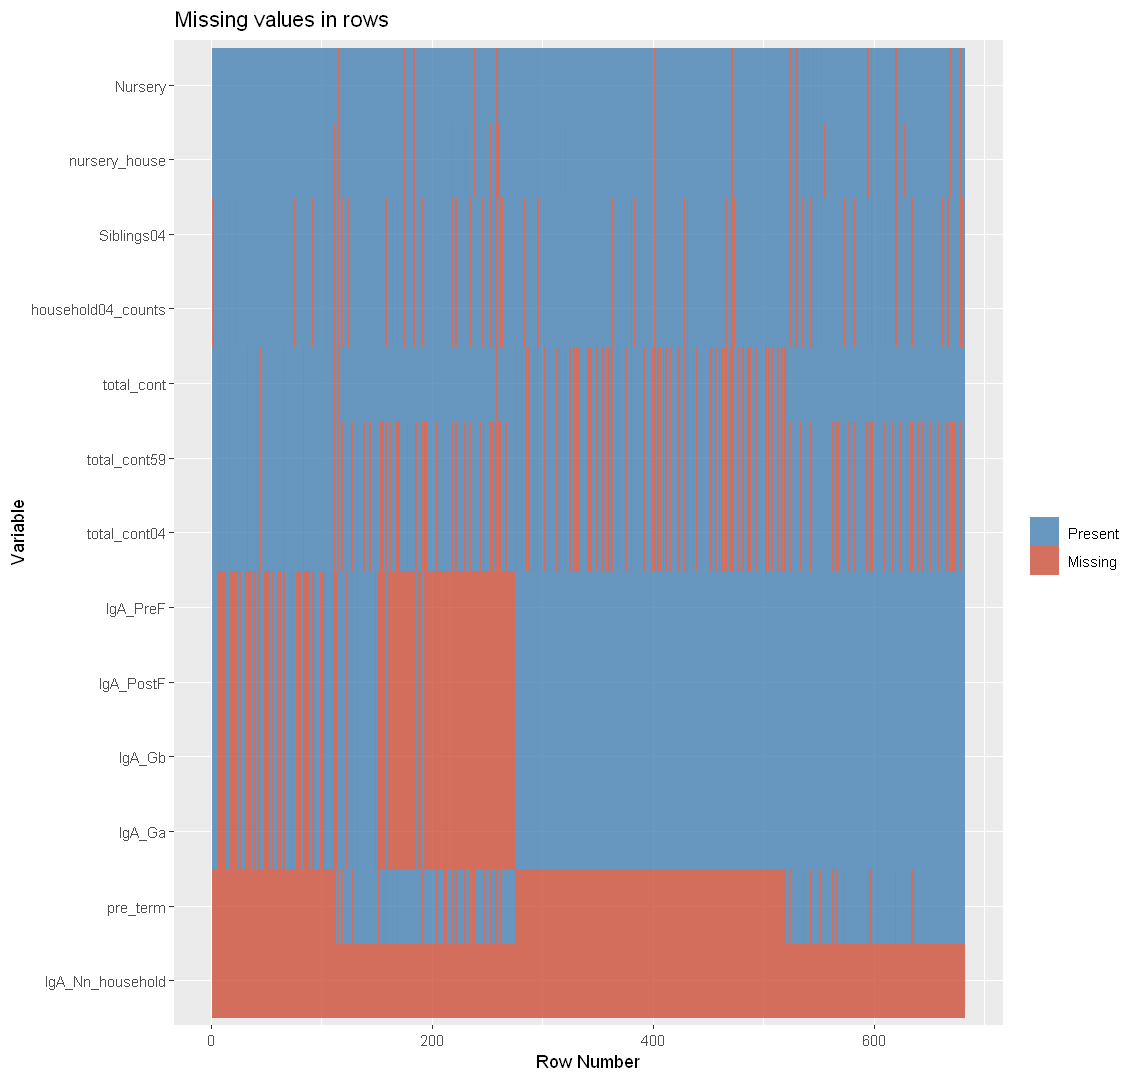

In [16]:
options(repr.plot.width = 9.5, repr.plot.height = 9) 
row.plot <- clean %>%
  mutate(id = row_number()) %>%
  gather(-id, key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  ggplot(aes(key, id, fill = isna)) +
    geom_raster(alpha=0.8) +
    scale_fill_manual(name = "",
        values = c('steelblue', 'tomato3'),
        labels = c("Present", "Missing")) +
    scale_x_discrete(limits = levels) +
    labs(x = "Variable",
           y = "Row Number", title = "Missing values in rows") +
    coord_flip()

row.plot

In [24]:
missing_cont <- subset(rsv.data, is.na(total_cont) == T)
get_summary_stats(missing_cont, show = c("n", "min", "max", "median", "mean", "sd"))

variable,n,min,max,median,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age_days,96,36.00,1843.000,181.000,269.771,302.966
Birth_doy,96,8.00,364.000,207.500,201.615,103.485
Birth_mo,96,1.00,12.000,7.000,7.094,3.412
household04,84,1.00,3.000,1.000,1.548,0.609
household04_counts,84,1.00,3.000,1.000,1.548,0.609
household59,96,0.00,3.000,0.000,0.292,0.614
IgA_Ga,89,0.01,1.000,0.020,0.040,0.105
IgA_Gb,89,0.01,0.530,0.020,0.028,0.056
IgA_PostF,89,0.02,29.860,0.050,1.385,4.940


In [25]:
#count total missing values in each column of data frame
sapply(missing_cont, function(x) sum(is.na(x)))

age_days           birthday        consultdate          infection 
                 0                  0                  0                  0 
          IgG_PreF           IgA_PreF          IgG_PostF          IgA_PostF 
                 0                  7                  0                  7 
            IgG_Ga             IgA_Ga             IgG_Gb             IgA_Gb 
                 0                  7                  0                  7 
             IgG_N   IgA_Nn_household        household04        household59 
                 0                 96                 12                  0 
visitnursery_child visitnursery_house      pregnancytime       contacttotal 
                 4                  6                 96                 96 
         contact04          contact59                sex          Birth_doy 
                96                 96                  0                  0 
household04_counts         Siblings04         Siblings59            Nursery 
                12                 12                  0                  4 
          Birth_mo          age_years            seasons             cohort 
                 0                  0                  0                  0 
      season_birth      nursery_house           pre_term         total_cont 
                 0                  6                 96                 96 
      total_cont04       total_cont59 
                96                 96

In [43]:
missing_cont %$% prop.table(table(age_years, useNA = "ifany"))*100

age_years
 0-6 months   1-2 years   2-3 years   3-4 years   4-5 years 6-12 months 
     51.042       9.375       1.042       2.083       2.083      34.375 

In [44]:
missing_cont %$% prop.table(table(infection, useNA = "ifany"))*100

infection
    0     1 
72.92 27.08 

In [45]:
missing_cont %$% prop.table(table(season_birth, useNA = "ifany"))*100

season_birth
Autumn Spring Summer Winter 
 28.12  22.92  25.00  23.96 

In [46]:
missing_cont %$% prop.table(table(Nursery, useNA = "ifany"))*100

Nursery
 False   True   <NA> 
77.083 18.750  4.167 

In [47]:
options(digits = 4)  
tab <- table(missing_cont$age_years, missing_cont$infection)
ptab <- prop.table(tab, margin=1)*100
dframe <- data.frame(values=rownames(tab), infected=ptab[,2])
dframe <- dframe[c(1,6,2:5), ]
dframe

,values,infected
,<chr>,<dbl>
0-6 months,0-6 months,4.082
6-12 months,6-12 months,33.333
1-2 years,1-2 years,88.889
2-3 years,2-3 years,100.000
3-4 years,3-4 years,100.000
4-5 years,4-5 years,100.000


In [35]:
get_summary_stats(complete_cont, show = c("n", "min", "max", "median", "mean", "sd"))

variable,n,min,max,median,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age_days,586,37.000,1854.00,373.000,581.753,460.408
Birth_doy,586,1.000,365.00,192.500,187.411,102.164
Birth_mo,586,1.000,12.00,7.000,6.676,3.368
household04_counts,537,1.000,3.00,1.000,1.458,0.610
household59,586,0.000,3.00,0.000,0.360,0.660
IgA_Ga,408,0.010,7.22,0.020,0.067,0.387
IgA_Gb,408,0.010,18.30,0.020,0.116,0.948
IgA_PostF,408,0.010,350.00,0.090,2.519,17.908
IgA_PreF,408,0.010,350.00,0.020,2.988,20.017


In [57]:
complete_cont <- subset(rsv.data, is.na(total_cont) == F)
tab <- table(complete_cont$age_years, complete_cont$infection)
ptab <- prop.table(tab, margin=1)*100
dframe <- data.frame(values=rownames(tab), infected=ptab[,2])
dframe <- dframe[c(1,6,2:5), ]
dframe

,values,infected
,<chr>,<dbl>
0-6 months,0-6 months,5.263
6-12 months,6-12 months,29.843
1-2 years,1-2 years,70.370
2-3 years,2-3 years,95.833
3-4 years,3-4 years,100.000
4-5 years,4-5 years,100.000


In [41]:
complete_cont %$% prop.table(table(season_birth, useNA = "ifany"))*100

season_birth
Autumn Spring Summer Winter 
 24.91  25.94  26.96  22.18 

In [49]:
complete_cont %$% prop.table(table(Nursery, useNA = "ifany"))*100

Nursery
 False   True   <NA> 
54.096 42.833  3.072 

In [58]:
complete_cont <- subset(rsv.data, is.na(total_cont) == F)
tab <- table(complete_cont$age_years, complete_cont$Nursery)
ptab <- prop.table(tab, margin=1)*100
dframe <- data.frame(values=rownames(tab), Nursery=ptab[,2])
dframe <- dframe[c(1,6,2:5), ]
dframe

,values,Nursery
,<chr>,<dbl>
0-6 months,0-6 months,19.78
6-12 months,6-12 months,43.41
1-2 years,1-2 years,40.60
2-3 years,2-3 years,67.61
3-4 years,3-4 years,88.46
4-5 years,4-5 years,15.38


In [51]:
tab <- table(missing_cont$age_years, missing_cont$Nursery)
ptab <- prop.table(tab, margin=1)*100
dframe <- data.frame(values=rownames(tab), Nursery=ptab[,2])
dframe <- dframe[c(1,6,2:5), ]
dframe

,values,Nursery
,<chr>,<dbl>
0-6 months,0-6 months,14.29
6-12 months,6-12 months,21.88
1-2 years,1-2 years,42.86
2-3 years,2-3 years,NaN
3-4 years,3-4 years,50.00
4-5 years,4-5 years,0.00


In [71]:
age_gp <- subset(rsv.data, age_years == "0-6 months")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )%>%
    mutate(
        infection = case_when(
            infection == 1 ~ "Infected",
            infection == 0 ~ "Not infected"
            )
        )

In [74]:
one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")

In [75]:
three <- rbind(one, two)

In [77]:
car.data = table(three$missing, three$infection) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              Infected Not infected
  Missing            2           47
  Not missing        5           90


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 2e-30, df = 1, p-value = 1



In [78]:
age_gp <- subset(rsv.data, age_years == "6-12 months")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )%>%
    mutate(
        infection = case_when(
            infection == 1 ~ "Infected",
            infection == 0 ~ "Not infected"
            )
        )

In [79]:
one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$infection) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              Infected Not infected
  Missing           11           22
  Not missing       57          134

	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 0.039, df = 1, p-value = 0.8



In [81]:
age_gp <- subset(rsv.data, age_years == "1-2 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )%>%
    mutate(
        infection = case_when(
            infection == 1 ~ "Infected",
            infection == 0 ~ "Not infected"
            )
        )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$infection) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              Infected Not infected
  Missing            8            1
  Not missing       95           40


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 0.66, df = 1, p-value = 0.4



In [82]:
age_gp <- subset(rsv.data, age_years == "2-3 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )%>%
    mutate(
        infection = case_when(
            infection == 1 ~ "Infected",
            infection == 0 ~ "Not infected"
            )
        )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$infection) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              Infected Not infected
  Missing            1            0
  Not missing       69            3


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 3.5e-29, df = 1, p-value = 1



In [101]:
age_gp <- subset(rsv.data, age_years == "0-6 months")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing        42    7
  Not missing    73   18

	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 0.33, df = 1, p-value = 0.6



In [102]:
age_gp <- subset(rsv.data, age_years == "6-12 months")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing        25    7
  Not missing   103   79

	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 4.4, df = 1, p-value = 0.04



In [103]:
age_gp <- subset(rsv.data, age_years == "1-2 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing         4    3
  Not missing    79   54


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 2e-30, df = 1, p-value = 1



In [105]:
age_gp <- subset(rsv.data, age_years == "2-3 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing         0    0
  Not missing    23   48


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test

data:  car.data
X-squared = NaN, df = 1, p-value = NA



In [106]:
age_gp <- subset(rsv.data, age_years == "3-4 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing         1    1
  Not missing     6   46


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 0.27, df = 1, p-value = 0.6



In [107]:
age_gp <- subset(rsv.data, age_years == "4-5 years")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))

             
              False True
  Missing         2    0
  Not missing    33    6


Warning message in chisq.test(car.data):
"Chi-squared approximation may be incorrect"



	Pearson's Chi-squared test with Yates' continuity correction

data:  car.data
X-squared = 4.5e-29, df = 1, p-value = 1



In [ ]:
age_gp <- subset(rsv.data, age_years == "0-6 months")
age_gp <- age_gp %>%
mutate(
    missing = case_when(
      is.na(total_cont) == T ~ "Missing",  #because the child itself is also included in household size
      is.na(total_cont) == F ~ "Not missing"       #the household04 of children of age 5 should also include the child itself
      )
    )

one <- subset(age_gp, missing == "Missing")
two <- subset(age_gp, missing == "Not missing")
three <- rbind(one, two)
car.data = table(three$missing, three$Nursery) 
print(car.data)

# Perform the Chi-Square test.
print(chisq.test(car.data))